<a href="https://colab.research.google.com/github/cateto/python4NLP/blob/main/colab/spam_detection_11_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")

('spam.csv', <http.client.HTTPMessage at 0x7fc2ba6dddd0>)

In [6]:
data = pd.read_csv('spam.csv', encoding='latin1')
print("총 샘플의 수 ", len(data))
data[:5]

총 샘플의 수  5572


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [11]:
data.isnull().values.any()

False

In [15]:
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

In [16]:
data.drop_duplicates(subset=['v2'], inplace=True)

In [17]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


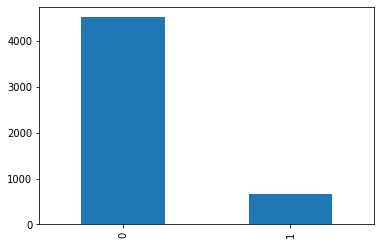

In [21]:
data['v1'].value_counts().plot(kind='bar')

In [22]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [24]:
X_data = data['v2']
Y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(Y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [26]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [27]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'call': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'at': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'when': 46, 'go': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'come': 59, 'am': 60, 'was': 61, 'time': 62, 'its': 63, 'only': 64, 'day': 65, 'want': 66, 'love': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'going': 72, 'one': 73, 'need': 74, 'by': 75, 'lor': 76, 'home': 77, 'as': 78, 'about': 79, 'still': 80, 'see': 81, 'txt': 82, 'back': 83, 'r': 84, 'stop': 85, 'da': 86, 'k': 87, 'today': 88, 'our': 89, "i'll": 90, 'dont': 91, 'reply': 

In [30]:
threshold = 2
total_cnt = len(word_to_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


In [31]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기:{}'.format((vocab_size)))

단어 집합의 크기:8921


In [32]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


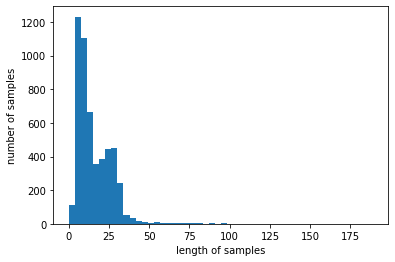

In [40]:
X_data = sequences
print('메일의 최대 길이 : %d' %max(len(l) for l in X_data)) 
print('메일의 평균 길이 : %f' %(sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


In [43]:
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(Y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(Y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

모델 설계 start !!

In [53]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
52/52 [==============================] - 3s 49ms/step - loss: 0.3952 - acc: 0.8733 - val_loss: 0.2876 - val_acc: 0.8791
Epoch 2/3
52/52 [==============================] - 2s 45ms/step - loss: 0.1296 - acc: 0.9695 - val_loss: 0.1002 - val_acc: 0.9710
Epoch 3/3
52/52 [==============================] - 2s 46ms/step - loss: 0.0560 - acc: 0.9873 - val_loss: 0.0725 - val_acc: 0.9782


In [54]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 9ms/step - loss: 0.0732 - acc: 0.9816

 테스트 정확도: 0.9816


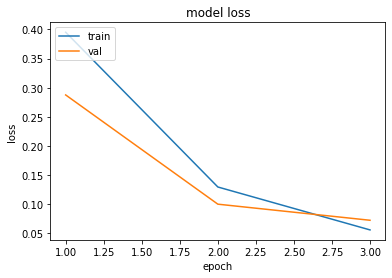

In [55]:
epochs = range(1, len(history.history['acc']) +1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()